#Imports

In [1]:
!pip install mtcnn
from mtcnn import MTCNN

import sys, os, argparse

import numpy as np
import cv2
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
from PIL import Image
from google.colab.patches import cv2_imshow
import numpy as np


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 14.0 MB/s 


In [2]:
# #download weights
# !gdown 1m25PrSE7g9D2q2XJVMR6IA7RaCvWSzCR

Downloading...
From: https://drive.google.com/uc?id=1m25PrSE7g9D2q2XJVMR6IA7RaCvWSzCR
To: /content/hopenet_robust_alpha1.pkl
100% 95.9M/95.9M [00:00<00:00, 113MB/s] 


#Get Trained weights

In [ ]:
!git clone https://github.com/natanielruiz/deep-head-pose.git dhp
# !gdown 1m25PrSE7g9D2q2XJVMR6IA7RaCvWSzCR

#Utils

In [3]:

import numpy as np
import torch
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin

def softmax_temperature(tensor, temperature):
    result = torch.exp(tensor / temperature)
    result = torch.div(result, torch.sum(result, 1).unsqueeze(1).expand_as(result))
    return result

def get_pose_params_from_mat(mat_path):
    # This functions gets the pose parameters from the .mat
    # Annotations that come with the Pose_300W_LP dataset.
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll, tdx, tdy]
    pose_params = pre_pose_params[:5]
    return pose_params

def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    pt2d = mat['pt2d']
    return pt2d

def mse_loss(input, target):
    return torch.sum(torch.abs(input.data - target.data) ** 2)

def plot_pose_cube(img, yaw, pitch, roll, tdx=None, tdy=None, size=150.):
    # Input is a cv2 image
    # pose_params: (pitch, yaw, roll, tdx, tdy)
    # Where (tdx, tdy) is the translation of the face.
    # For pose we have [pitch yaw roll tdx tdy tdz scale_factor]

    p = pitch * np.pi / 180
    y = -(yaw * np.pi / 180)
    r = roll * np.pi / 180
    if tdx != None and tdy != None:
        face_x = tdx - 0.50 * size
        face_y = tdy - 0.50 * size
    else:
        height, width = img.shape[:2]
        face_x = width / 2 - 0.5 * size
        face_y = height / 2 - 0.5 * size

    x1 = size * (cos(y) * cos(r)) + face_x
    y1 = size * (cos(p) * sin(r) + cos(r) * sin(p) * sin(y)) + face_y
    x2 = size * (-cos(y) * sin(r)) + face_x
    y2 = size * (cos(p) * cos(r) - sin(p) * sin(y) * sin(r)) + face_y
    x3 = size * (sin(y)) + face_x
    y3 = size * (-cos(y) * sin(p)) + face_y

    # Draw base in red
    cv2.line(img, (int(face_x), int(face_y)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(face_x), int(face_y)), (int(x2),int(y2)),(0,0,255),3)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x1-face_x),int(y2+y1-face_y)),(0,0,255),3)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x2-face_x),int(y1+y2-face_y)),(0,0,255),3)
    # Draw pillars in blue
    cv2.line(img, (int(face_x), int(face_y)), (int(x3),int(y3)),(255,0,0),2)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x3-face_x),int(y1+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x3-face_x),int(y2+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2+x1-face_x),int(y2+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(255,0,0),2)
    # Draw top in green
    cv2.line(img, (int(x3+x1-face_x),int(y3+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x2+x3-face_x),int(y2+y3-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x1-face_x),int(y3+y1-face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x2-face_x),int(y3+y2-face_y)),(0,255,0),2)

    return img

def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img


#Model

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import torch.nn.functional as F

class Hopenet(nn.Module):
    # Hopenet with 3 output layers for yaw, pitch and roll
    # Predicts Euler angles by binning and regression with the expected value
    def __init__(self, block, layers, num_bins):
        self.inplanes = 64
        super(Hopenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc_yaw = nn.Linear(512 * block.expansion, num_bins)
        self.fc_pitch = nn.Linear(512 * block.expansion, num_bins)
        self.fc_roll = nn.Linear(512 * block.expansion, num_bins)

        # Vestigial layer from previous experiments
        self.fc_finetune = nn.Linear(512 * block.expansion + 3, 3)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        pre_yaw = self.fc_yaw(x)
        pre_pitch = self.fc_pitch(x)
        pre_roll = self.fc_roll(x)

        return pre_yaw, pre_pitch, pre_roll



#Main

In [9]:
cudnn.enabled = True
gpu = 0
snapshot_path = "./hopenet_robust_alpha1.pkl"
model = Hopenet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 66)

# Load snapshot
saved_state_dict = torch.load(snapshot_path)
model.load_state_dict(saved_state_dict)


transformations = transforms.Compose([transforms.Resize(224),
transforms.CenterCrop(224), transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


model.cuda(gpu)



# Test the Model
model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
total = 0

idx_tensor = [idx for idx in range(66)]
idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)

yaw_error = .0
pitch_error = .0
roll_error = .0


def test(path, draw_axis= False):
    img = Image.open(path)
    
    img1 = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    #assuming one face
    face=detector.detect_faces(img1)[0]['box']
    x,y,w,h=face
    
    img=img.crop((int(x-20),int(y-20),int(x+w+20),int(y+h+20)))

    img = img.convert('RGB')
    
    cv2_img=np.asarray(img)

    cv2_img=cv2.resize(cv2_img,(224,224))[:,:,::-1]
    cv2_img = cv2_img.astype(np.uint8).copy() 
    cv2.imwrite('/content/before_transformation.jpg', cv2_img)
    img = transformations(img)
    cv2.imwrite('/content/after_transformation.jpg', cv2_img)
    
    img=img.unsqueeze(0)
    
    images = Variable(img).cuda(gpu)
    

    yaw, pitch, roll = model(images)

    # Binned predictions
    _, yaw_bpred = torch.max(yaw.data, 1)
    _, pitch_bpred = torch.max(pitch.data, 1)
    _, roll_bpred = torch.max(roll.data, 1)

    # Continuous predictions
    yaw_predicted = softmax_temperature(yaw.data, 1)
    pitch_predicted = softmax_temperature(pitch.data, 1)
    roll_predicted = softmax_temperature(roll.data, 1)

    yaw_predicted = torch.sum(yaw_predicted * idx_tensor, 1).cpu() * 3 - 99
    pitch_predicted = torch.sum(pitch_predicted * idx_tensor, 1).cpu() * 3 - 99
    roll_predicted = torch.sum(roll_predicted * idx_tensor, 1).cpu() * 3 - 99

    
  
    pitch = pitch_predicted[0]
    yaw = -yaw_predicted[0] 
    roll = roll_predicted[0] 
    print("pitch,yaw,roll",pitch,yaw,roll)  
    if draw_axis:    
      draw_axis(cv2_img, yaw_predicted[0], pitch_predicted[0], roll_predicted[0], size=100)
      cv2.imwrite('/content/res.jpg', cv2_img)



1/1 [==============================] - 0s 111ms/step
pitch,yaw,roll tensor(2.6737) tensor(-1.0223) tensor(-1.2108)


In [ ]:
test("/content/testdata.jpg", draw_axis=True)

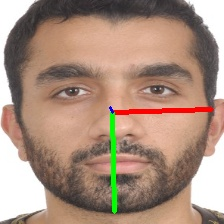

In [7]:
#view result
img=cv2.imread('/content/res.jpg')
cv2_imshow(img)
